In [1]:
import tensorflow as tf
print("Tensor Flow version: {}".format(tf.__version__))
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io

Tensor Flow version: 1.2.1


Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [38]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [46]:
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
path = "./UW_deep_learning/data/"

iris_file="iris.csv"
file_iris = os.path.join(path,iris_file)
df=pd.read_csv(file_iris,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")


# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(5, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1],activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor], verbose=2,epochs=1000)

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train on 112 samples, validate on 38 samples
Epoch 1/1000
0s - loss: 0.8572 - val_loss: 0.8334
Epoch 2/1000
0s - loss: 0.8357 - val_loss: 0.8067
Epoch 3/1000
0s - loss: 0.8102 - val_loss: 0.7805
Epoch 4/1000
0s - loss: 0.7794 - val_loss: 0.7591
Epoch 5/1000
0s - loss: 0.7588 - val_loss: 0.7421
Epoch 6/1000
0s - loss: 0.7421 - val_loss: 0.7276
Epoch 7/1000
0s - loss: 0.7274 - val_loss: 0.7131
Epoch 8/1000
0s - loss: 0.7140 - val_loss: 0.7002
Epoch 9/1000
0s - loss: 0.7002 - val_loss: 0.6886
Epoch 10/1000
0s - loss: 0.6881 - val_loss: 0.6796
Epoch 11/1000
0s - loss: 0.6781 - val_loss: 0.6703
Epoch 12/1000
0s - loss: 0.6682 - val_loss: 0.6603
Epoch 13/1000
0s - loss: 0.6588 - val_loss: 0.6495
Epoch 14/1000
0s - loss: 0.6492 - val_loss: 0.6380
Epoch 15/1000
0s - loss: 0.6411 - val_loss: 0.6266
Epoch 16/1000
0s - loss: 0.6311 - val_loss: 0.6165
Epoch 17/1000
0s - loss: 0.6227 - val_loss: 0.6066
Epoch 18/1000
0s - loss: 0.6139 - val_loss: 0.5973
Epoch 19/1000
0s - loss: 0.6062 - val_loss: 0.

In [29]:
pred = model.predict(x_test)

In [30]:
predict = np.argmax(pred,axis=1)
print (predict)

[1 0 2 1 1 0 1 2 2 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [31]:
from sklearn import metrics

y_compare = np.argmax(y_test, axis=1)
score = metrics.accuracy_score(y_compare, predict)
print ("Accuracy score: {}".format(score))

Accuracy score: 0.9736842105263158


# Calculate Accuracy score with Log-loss

In [32]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

#generate predictions
pred = model.predict(x_test)

print("Numpy array of prediction")
print (pred[0]*100)

print("As percentage probability")

display(pred[:5])

score = metrics.log_loss(y_test,pred)
print ("Log loss score: {}".format(score))



Numpy array of prediction
[ 0.0785 92.293   7.6285]
As percentage probability


array([[0.0008, 0.9229, 0.0763],
       [0.9999, 0.0001, 0.    ],
       [0.0008, 0.0068, 0.9924],
       [0.0016, 0.8103, 0.188 ],
       [0.0009, 0.8456, 0.1534]], dtype=float32)

Log loss score: 0.08401772963083874


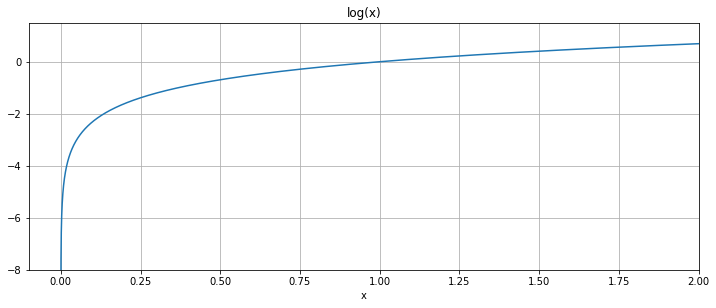

In [33]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

t = arange(1e-5, 5.0, 0.0001)

fig = figure(1,figsize=(12,10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-.1,2))
ax1.set_xlabel('x')
ax1.set_title('log(x)')
show()

# Regression 

In [34]:

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train on 298 samples, validate on 100 samples
Epoch 1/1000
0s - loss: 1766954.7336 - val_loss: 703652.8125
Epoch 2/1000
0s - loss: 330941.5853 - val_loss: 41179.2986
Epoch 3/1000
0s - loss: 10421.2190 - val_loss: 20659.9627
Epoch 4/1000
0s - loss: 31302.0810 - val_loss: 31620.2797
Epoch 5/1000
0s - loss: 18020.6448 - val_loss: 4018.6630
Epoch 6/1000
0s - loss: 1150.0858 - val_loss: 830.1512
Epoch 7/1000
0s - loss: 1617.2619 - val_loss: 1532.9811
Epoch 8/1000
0s - loss: 995.1227 - val_loss: 226.8161
Epoch 9/1000
0s - loss: 196.9447 - val_loss: 267.9817
Epoch 10/1000
0s - loss: 265.8554 - val_loss: 241.1837
Epoch 11/1000
0s - loss: 199.4740 - val_loss: 158.5872
Epoch 12/1000
0s - loss: 180.7326 - val_loss: 158.8536
Epoch 13/1000
0s - loss: 179.8226 - val_loss: 158.8252
Epoch 14/1000
0s - loss: 174.6246 - val_loss: 162.9010
Epoch 15/1000
0s - loss: 175.4619 - val_loss: 160.5696
Epoch 16/1000
0s - loss: 175.2731 - val_loss: 161.0389
Epoch 17/1000
0s - loss: 174.5193 - val_loss: 157.6252
Ep

In [35]:
# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 158.3580780029297


In [36]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 12.584040641784668


# Cross validation Regression

In [45]:
from sklearn.model_selection import KFold

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Preprocessing

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")


# K-FOLD Validation

kf = KFold(5)

oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x):
    fold += 1
    print ("fold #{}".format(fold))
    
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation = 'relu'))
#     model.add(Dense(1))
#     model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode = 'auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor], verbose=0, epochs=1000)
    pred = model.predict(x_test)
    oos_y.append(y_test)
    oos_pred.append(pred)
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print ("Fold score (RMSE) {}".format(score))
    

#Build the oos prediction list and calculate the error

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y, oos_pred))
print ("Final score (RMSE:) {} ".format(score))

oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat([df, oos_y, oos_pred], axis= 1)
filename_write = 'crossvalidation.csv'
oosDF.to_csv(filename_write,index=False)

# Split into train/test
# x_train, x_test, y_train, y_test = train_test_split(    
#     x, y, test_size=0.25, random_state=45)
# model.compile(loss='mean_squared_error', optimizer='adam')
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
# model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


fold #1
Epoch 00014: early stopping
Fold score (RMSE) 9.949836730957031
fold #2
Epoch 00287: early stopping
Fold score (RMSE) 3.847343683242798
fold #3
Epoch 00047: early stopping
Fold score (RMSE) 8.513518333435059
fold #4
Epoch 00013: early stopping
Fold score (RMSE) 13.908507347106934
fold #5
Epoch 00281: early stopping
Fold score (RMSE) 3.613138437271118
Final score (RMSE:) 8.856208801269531 


# Classification-Cross Validation

In [60]:
path = "./UW_deep_learning/data/"

iris_file="iris.csv"
file_iris = os.path.join(path,iris_file)
df=pd.read_csv(file_iris,na_values=['NA','?'])


np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop= True)

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

kf = KFold(5)

oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x):
    fold+=1
    print ("Fold {}:".format(fold))
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(5, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor], verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1)
    oos_pred.append(pred)
    
    y_compare = np.argmax(y_test,axis=1)
#     print ("shape of test data input, output : {} {} {} {}". format(pred.shape, y_test.shape, np.argmax(y_test,axis=1).shape))

    score = metrics.accuracy_score(y_compare, pred)
    print("FOld score (accuracy): ".format(score))
    

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1)
score = np.sqrt(metrics.mean_squared_error(oos_y_compare, oos_pred))
print ("Final score (RMSE:) {} ".format(score))

oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat([df, oos_y, oos_pred], axis= 1)
filename_write = 'crossvalidation_classification.csv'
oosDF.to_csv(filename_write,index=False)
    


# Split into train/test
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)



/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Fold 1:
Epoch 00307: early stopping
FOld score (accuracy): 
Fold 2:
Epoch 00244: early stopping
FOld score (accuracy): 
Fold 3:
Epoch 00275: early stopping
FOld score (accuracy): 
Fold 4:
Epoch 00287: early stopping
FOld score (accuracy): 
Fold 5:
Epoch 00333: early stopping
FOld score (accuracy): 
Final score (RMSE:) 0.16329931618554522 
